In [ ]:
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier as DTC 
from sklearn.model_selection import train_test_split

In [ ]:
#创建随机数据集
X,y=make_classification(
    n_samples=1000,   #数据集大小
    n_features=16,    #特征数，即数据维度
    n_informative=5,  #有效特征数   真正对目标变量（即标签）有预测能力的特征。
    n_redundant=2,    #冗余特征个数，这些特征本身没有直接的预测能力，但它们是由有效特征线性组合而成的 ，因此携带了一些“间接信息”。
    #其他的特征为Noise / Repeated  :不相关或重复的特征（模拟噪声）
    n_classes=2,      #类别数
    #类别随机的样本个数,该值越大，分类越困难,这是概率值，表示有多少比例的样本的标签会被随机翻转（即错误标记）。
    #它模拟了现实世界中的标签噪声
    #如果你设置 flip_y=0.1，那么大约有10%的样本会被随机分配一个错误的类别标签。
    flip_y=0.1,     
    random_state=0    #随机种子
)


print(X.shape)
print(y.shape)

(1000, 16)
(1000,)


In [ ]:
class RandomForest():

    def __init__(self,n_trees=10,max_features='sqrt'):
        #n_trees:森林中决策树的数量，默认是 10。
        #max_features: 每棵树在节点分裂时随机选择的特征数量策略，默认是 'sqrt'。
        # 值               示例                   含义
        # None                                   使用所有特征（默认情况下）
        # int=10           max_features=10       每次从 100 个中随机选 10 个
        # float=0.1        max_features=0.1      表示使用总特征数的百分比（如 30%）
        # "sqrt" 或 "auto" max_features='sqrt'   自动选择 √n_features 个特征（分类任务常用）
        # "log2"           max_features='log2'   使用 log2(n_features) 个特征（回归任务常用）
        self.n_trees=n_trees
        self.oob_score=0
        self.trees=[DTC(max_features=max_features) for _ in range(n_trees)]

    def fit(self,X,y):
        n_samples,n_features=X.shape
        self.n_classes=np.unique(y).shape[0]
        #集成模型的预测，累加单个模型预测的分类概率，再取较大值作为最终分类
        ensemble=np.zeros((n_samples,self.n_classes))

        for tree in self.trees:
            #自举采样，该采样允许重复
            idx=np.random.randint(0,n_samples,n_samples)
            #没有被采到的样本
            unsampled_mask=np.bincount(idx,minlength=n_samples)==0  #np.bincount 统计每个索引在 idx 数组中出现的次数
            unsampled_idx=np.arange(n_samples)[unsampled_mask]
            #训练当前的决策树
            tree.fit(X[idx],y[idx])
            #累加决策树对OOB样本的预测
            ensemble[unsampled_mask]+=tree.predict_proba(X[unsampled_idx])  #调用当前决策树模型对这些 OOB 样本做预测，输出的是一个概率矩阵，形状为 (n_unsampled, n_classes)。
        #计算OOB分数，由于是分类任务，我们用正确率来衡量
        self.oob_score=np.mean(y==np.argmax(ensemble,axis=1))  #argmax对每一行找出最大值所在的列索引,刚好与预测的类别相同。
    
    #预测类别
    def predict(self,X):
        proba=self.predict_proba(X)
        return np.argmax(proba,axis=1)
    
    #对输入数据 X，使用随机森林中的每一棵决策树进行预测，然后将它们的概率结果取平均，得到最终的类别概率预测
    def predict_proba(self,X):
        #取所有决策树预测概率的平均
        ensemble=np.mean([tree.predict_proba(X) for tree in self.trees],axis=0)
        return ensemble
    
    #计算正确率
    def score(self,X,y):
        return np.mean(y==self.predict(X))
    


### Bagging 与 Random Forest 关键区别


| 维度 | Bagging | Random Forest |
|------|---------|---------------|
| **基模型** | 可以是任意模型（如 SVM、决策树等） | 通常使用决策树 |
| **数据采样方式** | Bootstrap 有放回抽样 | Bootstrap 有放回抽样 |
| **特征选择** | 所有特征都参与分裂 | 每次分裂只用部分随机特征（`max_features` 控制） |
| **树之间的差异来源** | 主要来自不同的训练样本 | 来自样本不同 + 特征选择不同 |
| **多样性** | 较低（仅靠样本不同） | 更高（样本+特征双重随机） |
| **过拟合控制** | 优于单一模型，但不如 RF | 更好，因为更强的多样性 |
| **计算效率** | 相对更高 | 略低，因特征随机化增加了复杂度 |
| **OOB误差支持** | ✅ 支持 | ✅ 支持 |
| **特征重要性评估** | ❌ 不直接支持 | ✅ 支持（基于不纯度或置换重要性） |

100%|██████████| 20/20 [00:04<00:00,  4.18it/s, n_tree=96, train_score=1, oob_score=0.897]    


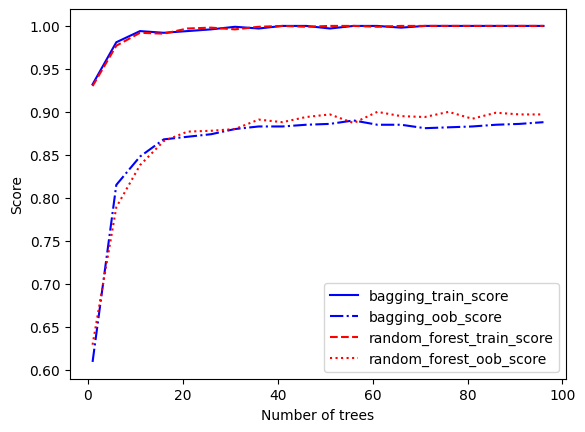

In [12]:
# 算法测试与可视化
num_trees = np.arange(1, 101, 5)
np.random.seed(0)
plt.figure()

# bagging算法
oob_score = []
train_score = []
with tqdm(num_trees) as pbar:
    for n_tree in pbar:
        rf = RandomForest(n_trees=n_tree, max_features=None)
        rf.fit(X, y)
        train_score.append(rf.score(X, y))
        oob_score.append(rf.oob_score)
        pbar.set_postfix({
            'n_tree': n_tree, 
            'train_score': train_score[-1], 
            'oob_score': oob_score[-1]
        })
plt.plot(num_trees, train_score, color='blue', 
    label='bagging_train_score')
plt.plot(num_trees, oob_score, color='blue', linestyle='-.', 
    label='bagging_oob_score')

# 随机森林算法
oob_score = []
train_score = []
with tqdm(num_trees) as pbar:
    for n_tree in pbar:
        rf = RandomForest(n_trees=n_tree, max_features='sqrt')
        rf.fit(X, y)
        train_score.append(rf.score(X, y))
        oob_score.append(rf.oob_score)
        pbar.set_postfix({
            'n_tree': n_tree, 
            'train_score': train_score[-1], 
            'oob_score': oob_score[-1]
        })
plt.plot(num_trees, train_score, color='red', linestyle='--', 
    label='random_forest_train_score')
plt.plot(num_trees, oob_score, color='red', linestyle=':', 
    label='random_forest_oob_score')

plt.ylabel('Score')
plt.xlabel('Number of trees')
plt.legend()
plt.show()